In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:

filename = "./data/wine.csv"
df = pd.read_csv(filename)
df.sample(frac=1).reset_index(drop=True) # Shuffle dataframe
# drop col index
df = df.drop(['index'],axis = 1)
df['quality'].value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

In [3]:
train_test_split_fraction = 1
split_index = int(df.shape[0] * train_test_split_fraction)
df_train = df[:split_index]
df_test = df[split_index:]

target = df['quality'].to_numpy()
target = target.reshape(6497,1) # One hot encode

X_train = df_train.drop('quality', axis = 1).values
X_test = df_test.drop('quality', axis = 1).values

y_train = target[:split_index]
y_test = target[split_index:]

In [4]:
input_cols = list(df.columns)[:-1]
output_cols = ['quality']

#def dataframe_to_arrays(df):
    # Make a copy of the original dataframe
    #df1 = df.copy(deep=True)
    # Extract input & outupts as numpy arrays
   # inputs_array = df1[input_cols].to_numpy()
  #  targets_array = df1[output_cols].to_numpy()
 #   return inputs_array, targets_array

#inputs_array, targets_array = dataframe_to_arrays(df)

#inputs = torch.Tensor(inputs_array)
#targets = torch.Tensor(targets_array)
#dataset = TensorDataset(inputs, targets)



In [5]:
dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float())
test_dataset = TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test).float())




In [6]:
num_classes = len(pd.unique(df['quality']))
input_size = len(input_cols)

In [7]:
size = len(dataset)    # 6497
split = 0.2                     
val_size = int(size*split)      # 1299
train_size = size - val_size    # 5198
 
train, val = random_split(dataset, [train_size, val_size])
print(size,val[0])

6497 (tensor([6.3000e+00, 3.4000e-01, 1.9000e-01, 5.8000e+00, 4.1000e-02, 2.2000e+01,
        1.4500e+02, 9.9430e-01, 3.1500e+00, 6.3000e-01, 9.9000e+00]), tensor([5.]))


In [8]:
batch_size = 20
train_loader = DataLoader(train, batch_size, shuffle = True)
val_loader = DataLoader(val, batch_size)
test_loader = DataLoader(test_dataset, batch_size)

nb_hidden_neurons = 10
nb_classes = len(pd.unique(df['quality']))

In [9]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        #layers of the model
        self.l1 = nn.Linear(input_size, nb_hidden_neurons)
        #self.l2 = nn.Linear(nb_hidden_neurons, nb_hidden_neurons)
        self.l2 = nn.Linear(nb_hidden_neurons, nb_classes)
        self.flat = nn.Flatten()
 
    def forward(self, x):
        #one forward pass
        out = self.flat(x)
        out = F.relu(self.l1(out))
        out = (self.l2(out))
     
        return out
 
    def training_step(self, batch):
        wines, labels  = batch
        out = self(wines)
        loss = F.l1_loss(out, labels) 
        return loss
 
    def validation_step(self, batch):
        wines, labels = batch
        out = self(wines)
      
        loss = F.l1_loss(out, labels)
     
        _, pred = torch.max(out, 1)
        accuracy = torch.tensor(torch.sum(pred==labels).item()/len(pred))
        return [loss.detach(), accuracy.detach()]

In [10]:
def evaluate(model, loader):

    outputs = [model.validation_step(batch) for batch in loader]
    outputs = torch.tensor(outputs).T
    loss, accuracy = torch.mean(outputs, dim=1)
    return {"loss": loss.item(), "accuracy": accuracy.item()}

In [11]:
def fit(model, train_loader, val_loader, epochs, lr, optimizer_function = torch.optim.SGD):
    history = []
    optimizer = optimizer_function(model.parameters(), lr)
    for epoch in range(epochs):
        print("Epoch ", epoch)
        #Train
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        #Validate
        for batch in val_loader:
            result = evaluate(model, val_loader)
        print("loss: ", result["loss"], "accuracy: ", result["accuracy"], "\n")
        history.append(result)
         
    return history

In [12]:
model = Network()
model.parameters

<bound method Module.parameters of Network(
  (l1): Linear(in_features=11, out_features=10, bias=True)
  (l2): Linear(in_features=10, out_features=7, bias=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
)>

In [13]:
history = fit(model, train_loader, val_loader, 30, 0.1)
evaluate(model, test_loader)

Epoch  0


TypeError: iteration over a 0-d tensor

In [14]:
losses = []
accuracies = []
for i in history:
    losses.append(i['loss'])
    accuracies.append(i['accuracy'])
def plot(var,title):
    plt.plot(var,'-x')
    plt.title()

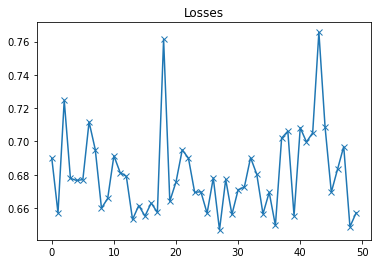

In [15]:
plot(losses,'Losses')

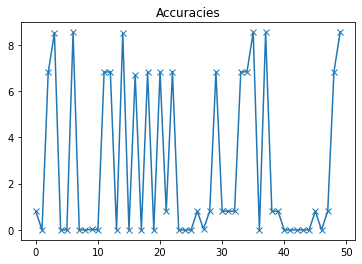

In [16]:
plot(accuracies, 'Accuracies')